In [1]:
from time import time
import os

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Layer, InputSpec
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.initializers import VarianceScaling
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sklearn.metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.manifold import TSNE

%matplotlib inline
np.random.seed(2021)
tf.random.set_seed(
    2021
)


In [2]:
class EncoderDecoderBlock(layers.Layer):

    def __init__(self,
                 dims,
                 activation,
                 init,
                 ):
        super(EncoderDecoderBlock, self).__init__()
        self.num_layers = dims
        self.layer_count = len(dims) - 1
        self.activation = activation
        self.init = init
        self.input_data = Input(shape=(dims[0],), name='input')
        self.encoder_layers = [
            layers.Dense(self.num_layers[i + 1], activation='relu') for i in range(self.layer_count - 1)]
        self.latent = layers.Dense(dims[-1], kernel_initializer=init)
        self.decoder_layers = [
            layers.Dense(self.num_layers[i], activation='relu', kernel_initializer=init) 
            for i in range(self.layer_count-1, 0, -1)]
    def call(self, loss, optimizer, metrics):

        inp = tf.keras.Input(shape=(dims[0],), name='input')
        x = inp
        for i in range(self.layer_count-1):
            x = self.encoder_layers[i](x)
        encoded = self.latent(x)

        x = encoded
        for i in range(self.layer_count-1):
            x = self.decoder_layers[i](x)       
        x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
        decoded = x        
        autoencoder_model = Model(inputs=inp, outputs=decoded, name='autoencoder')
        encoder_model = Model(inputs=inp, outputs=encoded, name='encoder')

        return autoencoder_model, encoder_model

class ClusteringLayer(Layer):

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(
            self.n_clusters, input_dim), initializer='glorot_uniform')

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):

        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs,
                                                       axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0

        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))

        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [18]:
from sklearn.preprocessing import MinMaxScaler
data = pd.read_csv('set_03.csv')
data = data.drop('label',axis=1)
numeric_columns = data.columns.values.tolist()
scaler = MinMaxScaler() 
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
x = data.values
x.shape
n_clusters = 3
n_epochs   = 50
batch_size = 32

In [19]:
x.shape

(53173, 50)

In [20]:
kmeans = KMeans(n_clusters=n_clusters, n_jobs=4)
y_pred_kmeans = kmeans.fit_predict(x)

F:\anaconda3\envs\kaggle\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


In [21]:
dims = [x.shape[-1], 500, 500, 2000, 10] 
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
activation = 'relu'

pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = n_epochs
batch_size = batch_size
save_dir = './results'

In [22]:
autoencoder = EncoderDecoderBlock(dims,activation,init)

In [23]:
loss='mse'
optimizer = 'adam'
metrics = 'accuracy'
autoencoder, encoder = autoencoder(loss, optimizer, metrics)

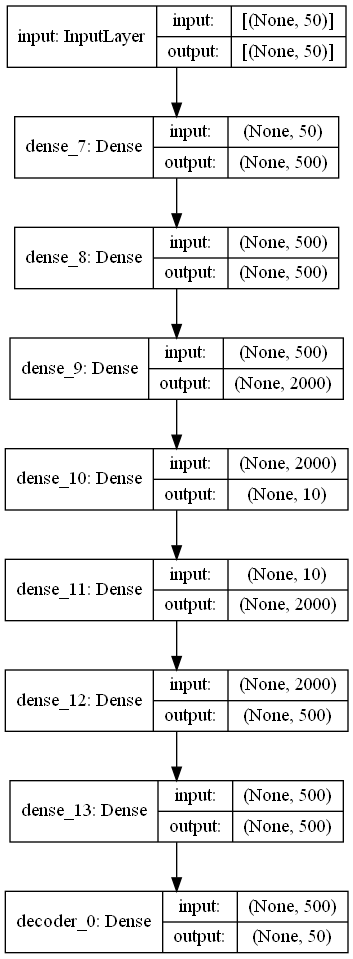

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png') 

In [25]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights('dan_1_weights.h5')

Epoch 1/50
1662/1662 [==============================] - 19s 11ms/step - loss: 0.0117
Epoch 2/50
1662/1662 [==============================] - 19s 11ms/step - loss: 0.0044
Epoch 3/50
1662/1662 [==============================] - 19s 11ms/step - loss: 0.0038
Epoch 4/50
1662/1662 [==============================] - 19s 11ms/step - loss: 0.0036
Epoch 5/50
1662/1662 [==============================] - 19s 12ms/step - loss: 0.0034
Epoch 6/50
1662/1662 [==============================] - 19s 12ms/step - loss: 0.0034
Epoch 7/50
1662/1662 [==============================] - 19s 11ms/step - loss: 0.0033
Epoch 8/50
1662/1662 [==============================] - 19s 11ms/step - loss: 0.0032
Epoch 9/50
1662/1662 [==============================] - 19s 11ms/step - loss: 0.0032
Epoch 10/50
1662/1662 [==============================] - 19s 11ms/step - loss: 0.0032
Epoch 11/50
1662/1662 [==============================] - 19s 11ms/step - loss: 0.0031
Epoch 12/50
1662/1662 [==============================] - 19s 11

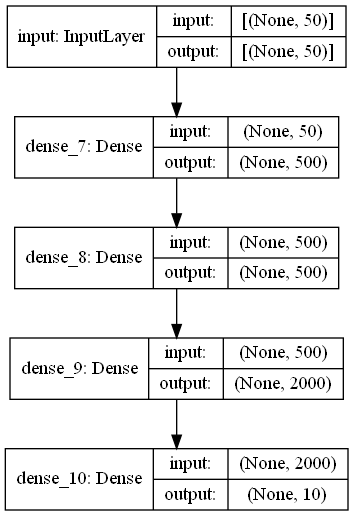

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png') 

In [27]:
autoencoder.save_weights('dan_1_weights.h5')
autoencoder.load_weights('dan_1_weights.h5')

In [28]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

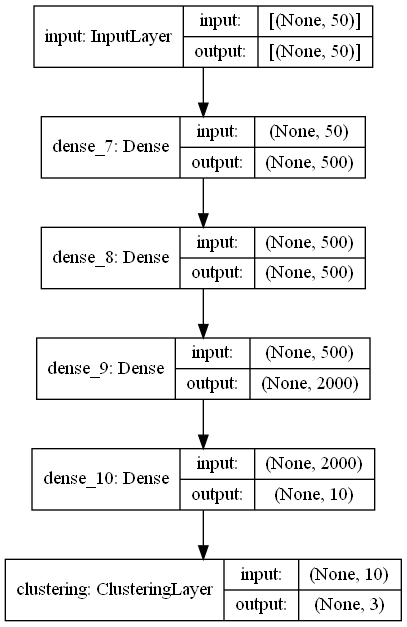

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 

In [30]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [31]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
# computing an auxiliary target distribution


loss = 0
index = 0
maxiter = 1000 
update_interval = 100 
index_array = np.arange(x.shape[0])

tol = 0.001 

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  

    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights('danaher_model_final.h5')
model.load_weights('danaher_model_final.h5')
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
df = data.copy()
df['cluster'] = y_pred
df['cluster'].value_counts()

1    30758
2    13561
0     8854
Name: cluster, dtype: int64

In [32]:
import numpy as np
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(x)

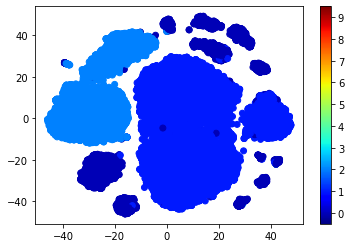

In [33]:
x_ = tsne[:, 0]
y_ = tsne[:, 1]
plt.scatter(x_, y_, c=y_pred, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()

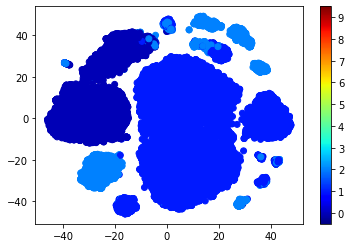

In [34]:
plt.scatter(x_, y_, c=y_pred_kmeans, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()

In [35]:
y_pred_kmeans.shape

(53173,)

In [36]:
from sklearn.metrics import silhouette_score
x = data.values
score = silhouette_score (x, y_pred_kmeans, metric='euclidean')
print ("clusters = {}, Kmeans silhouette score is {})".format(n_clusters, score))

clusters = 3, Kmeans silhouette score is 0.35437872936100223)


In [37]:
score = silhouette_score (x, y_pred, metric='euclidean')
print ("For n_clusters = {}, Deep clustering silhouette score is {})".format(n_clusters, score))

For n_clusters = 3, Deep clustering silhouette score is 0.326548506814464)


In [38]:
for num_clusters in range(2,10):
    clusterer = KMeans(n_clusters=num_clusters, n_jobs=4)
    preds = clusterer.fit_predict(x)
    # centers = clusterer.cluster_centers_
    score = silhouette_score (x, preds, metric='euclidean')
    print ("For n_clusters = {}, Kmeans silhouette score is {})".format(num_clusters, score))

F:\anaconda3\envs\kaggle\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


For n_clusters = 2, Kmeans silhouette score is 0.33226964321211294)


F:\anaconda3\envs\kaggle\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


For n_clusters = 3, Kmeans silhouette score is 0.35440200403347993)


F:\anaconda3\envs\kaggle\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


For n_clusters = 4, Kmeans silhouette score is 0.35699738260592073)


F:\anaconda3\envs\kaggle\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


For n_clusters = 5, Kmeans silhouette score is 0.25561916610525404)


F:\anaconda3\envs\kaggle\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


For n_clusters = 6, Kmeans silhouette score is 0.23856902018322584)


F:\anaconda3\envs\kaggle\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


For n_clusters = 7, Kmeans silhouette score is 0.17143025158516792)


F:\anaconda3\envs\kaggle\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


For n_clusters = 8, Kmeans silhouette score is 0.18575838557252664)


F:\anaconda3\envs\kaggle\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


For n_clusters = 9, Kmeans silhouette score is 0.17934292649565112)


In [39]:
autoencoder = EncoderDecoderBlock(dims,activation,init)
loss='mse'
optimzer = SGD(lr=1, momentum=0.9)
metrics = 'accuracy'
autoencoder, encoder = autoencoder(loss, optimizer, metrics)

In [40]:
autoencoder.load_weights('dan_1_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])

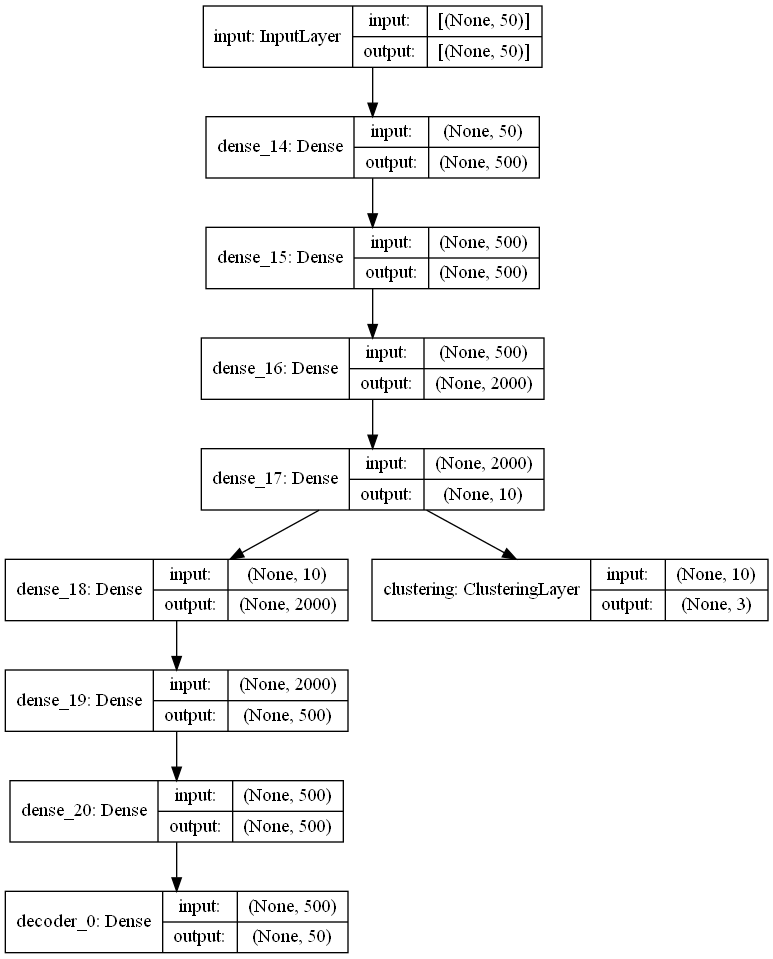

In [41]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [42]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [43]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights('b_DANAHER_model_final.h5')

In [44]:
model.load_weights('b_DANAHER_model_final.h5')
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)
y_pred = q.argmax(1)
score = silhouette_score (x, y_pred, metric='euclidean')
print ("For n_clusters = {}, Deep clustering silhouette score is {})".format(n_clusters, score))

For n_clusters = 3, Deep clustering silhouette score is 0.2734962139583704)


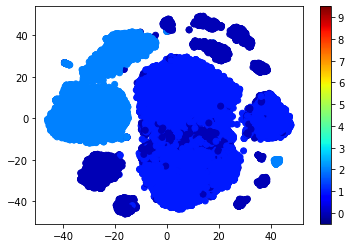

In [45]:
plt.scatter(x_, y_, c=y_pred, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()

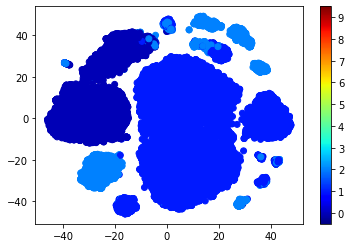

In [46]:
plt.scatter(x_, y_, c=y_pred_kmeans, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()

In [47]:
df['cluster'] = y_pred
df['cluster'].value_counts()
df_cluster_0 = df[df['cluster'] == 0]
df_cluster_0.describe()

,var01,var02,var03,var04,var05,var06,var07,var08,var09,var10,...,var42,var43,var44,var45,var46,var47,var48,var49,var50,cluster
count,11100.000000,11100.000000,11100.000000,11100.000000,11100.000000,11100.000000,11100.000000,11100.000000,11100.000000,11100.000000,...,11100.000000,11100.000000,11100.000000,11100.000000,11100.000000,11100.000000,11100.000000,11100.000000,11100.000000,11100.0
mean,0.352348,0.178328,0.212306,0.210745,0.146019,0.107517,0.124710,0.138725,0.395007,0.096240,...,0.075730,0.053799,0.044862,0.507604,0.187978,0.197831,0.194779,0.155854,0.527268,0.0
std,0.159047,0.085689,0.101605,0.097955,0.097059,0.096450,0.119246,0.155033,0.181096,0.078549,...,0.077049,0.052925,0.050483,0.169041,0.170015,0.140607,0.113531,0.155644,0.135052,0.0
min,0.000000,0.002407,0.004091,0.010542,0.000000,0.000222,0.000388,0.000477,0.000022,0.000295,...,0.000000,0.000041,0.000028,0.000991,0.000251,0.000524,0.000000,0.000605,0.000000,0.0
25%,0.235294,0.117127,0.139284,0.141082,0.076620,0.037814,0.035111,0.054518,0.261376,0.035318,...,0.027225,0.023371,0.014187,0.438620,0.059183,0.099666,0.116910,0.058965,0.428509,0.0
50%,0.323529,0.167557,0.199276,0.199143,0.128472,0.083786,0.089133,0.093694,0.399255,0.074216,...,0.047901,0.039374,0.028922,0.544755,0.134579,0.164023,0.168610,0.108695,0.518677,0.0
75%,0.441176,0.226142,0.269410,0.266156,0.194798,0.148881,0.172850,0.132634,0.524760,0.138573,...,0.093270,0.062008,0.058316,0.624656,0.269977,0.258680,0.241779,0.194582,0.633370,0.0
max,1.000000,0.915983,0.929683,0.867459,0.972533,1.000000,0.928958,0.989626,1.000000,0.542049,...,0.669465,0.689103,0.996970,0.933531,0.998321,0.989692,1.000000,1.000000,0.969219,0.0
